In [1]:
import os
import os.path
from pathlib import Path
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir('..')


In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime, date
parquet_files = []
start = "2012-12"
end = "2022-11"
fmt = "http://steam-bot-public.s3.amazonaws.com/market-archive/partition={partition}/part.0.parquet"
fmt_local = "./parquet/partition={partition}/part.0.parquet"
current_date = datetime.strptime(start, "%Y-%m").date()
end_date = datetime.strptime(end, "%Y-%m").date()
while current_date <= end_date:
    parquet_files.append((fmt.format(partition=current_date.strftime("%Y-%m")), fmt_local.format(partition=current_date.strftime("%Y-%m"))))
    new_year, new_month = current_date.year, current_date.month
    new_month += 1
    if new_month >= 13:
        new_year += 1
        new_month = 1
    current_date = date(year=new_year, month=new_month, day=1)


In [4]:
import aiohttp        
import aiofiles

async def _download_file(url, path: Path):
    if path.exists():
        return
    print(f"Downloading to '{path}' ...")
    async with aiohttp.ClientSession() as session:
        path.parent.mkdir(parents=True, exist_ok=True)
        async with session.get(url) as resp:
            if resp.status == 200:
                f = await aiofiles.open(path, mode='wb')
                await f.write(await resp.read())
                await f.close()

for url, path in parquet_files:
    await _download_file(url, Path(path))

In [5]:
from pyspark.sql import SparkSession
#.config("spark.memory.fraction", 0.8) \
    #.config("spark.sql.shuffle.partitions" , "800") \
    #.config("spark.memory.offHeap.enabled",'true')\
    #.config("spark.memory.offHeap.size","16g")\
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('myAppName') \
    .config("spark.executor.memory", "5g") \
    .config("spark.driver.memory", "5g")\
    .config("spark.sql.shuffle.partitions" , "50") \
    .config('spark.sql.files.maxPartitionBytes', str(30 * 1024 * 1024))\
    .getOrCreate()

In [6]:
import pyspark.sql.functions as func
from pyspark.sql.types import DecimalType, Row
from pyspark.sql import Window as W

In [7]:
parquet_files = []
for root, dirs, files in os.walk('parquet/'):
    for file in files:
        if file.endswith(".parquet"):
            parquet_files.append(f"{root}/{file}")
df = spark.read.parquet(*parquet_files)

In [8]:
df.count()

215911515

In [9]:
df.printSchema()

root
 |-- index: long (nullable = true)
 |-- app_id: long (nullable = true)
 |-- market_hash_name: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- price: double (nullable = true)
 |-- amount: long (nullable = true)



In [10]:
df = df.withColumn("timestamp",func.to_timestamp("timestamp"))

In [11]:
df.rdd.getNumPartitions()

107

In [12]:
df.explain(mode='formatted')

== Physical Plan ==
* Project (3)
+- * ColumnarToRow (2)
   +- Scan parquet  (1)


(1) Scan parquet 
Output [6]: [index#0L, app_id#1L, market_hash_name#2, timestamp#3, price#4, amount#5L]
Batched: true
Location: InMemoryFileIndex [file:/C:/Work/steam-trade-bot/parquet/partition=2012-12/part.0.parquet, ... 119 entries]
ReadSchema: struct<index:bigint,app_id:bigint,market_hash_name:string,timestamp:string,price:double,amount:bigint>

(2) ColumnarToRow [codegen id : 1]
Input [6]: [index#0L, app_id#1L, market_hash_name#2, timestamp#3, price#4, amount#5L]

(3) Project [codegen id : 1]
Output [6]: [index#0L, app_id#1L, market_hash_name#2, cast(timestamp#3 as timestamp) AS timestamp#23, price#4, amount#5L]
Input [6]: [index#0L, app_id#1L, market_hash_name#2, timestamp#3, price#4, amount#5L]




In [13]:
df.printSchema()

root
 |-- index: long (nullable = true)
 |-- app_id: long (nullable = true)
 |-- market_hash_name: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- amount: long (nullable = true)



In [14]:
df.show()

+-----+------+----------------+-------------------+-----+------+
|index|app_id|market_hash_name|          timestamp|price|amount|
+-----+------+----------------+-------------------+-----+------+
|    0|519870|         3x Ball|2020-05-16 01:00:00| 0.03|     1|
|    1|519870|            Bomb|2020-05-01 01:00:00| 0.03|     1|
|    2|519870|            Bomb|2020-05-03 01:00:00| 0.03|     3|
|    3|519870|            Bomb|2020-05-06 01:00:00| 0.03|     2|
|    4|519870|            Bomb|2020-05-07 01:00:00| 0.03|     1|
|    5|519870|            Bomb|2020-05-08 01:00:00| 0.03|     1|
|    6|519870|            Bomb|2020-05-10 01:00:00| 0.03|     1|
|    7|519870|            Bomb|2020-05-11 01:00:00| 0.03|     1|
|    8|519870|            Bomb|2020-05-12 01:00:00| 0.03|     1|
|    9|519870|            Bomb|2020-05-14 01:00:00| 0.03|     1|
|   10|519870|            Bomb|2020-05-16 01:00:00| 0.03|     5|
|   11|519870|            Bomb|2020-05-19 01:00:00| 0.03|     1|
|   12|519870|           

In [16]:
df.groupby("market_hash_name").sum("amount").sort("sum(amount)", ascending=False).show()

+--------------------+-----------+
|    market_hash_name|sum(amount)|
+--------------------+-----------+
|         Clutch Case|  134768975|
|        Gamma 2 Case|  121917096|
|       Chroma 3 Case|  101683679|
|    Danger Zone Case|   96496214|
|Operation Breakou...|   90903986|
|       Chroma 2 Case|   88739813|
|     Spectrum 2 Case|   85373019|
|Operation Phoenix...|   75896023|
|          Glove Case|   74989313|
|       Prisma 2 Case|   73218680|
|         Prisma Case|   71152439|
|       Fracture Case|   61277159|
|          Gamma Case|   58658775|
|       Spectrum Case|   57619436|
|       Falchion Case|   50606608|
|        Horizon Case|   45356078|
|         Shadow Case|   41687378|
|         Chroma Case|   41092006|
|           CS20 Case|   37828820|
|       Revolver Case|   37827226|
+--------------------+-----------+
only showing top 20 rows



In [17]:
df \
  .groupby("market_hash_name") \
  .agg( \
    func.sum(df.amount).alias("total_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.sum(df.price * df.amount).cast(DecimalType(38, 2)).alias("total_volume") \
  ) \
  .sort("total_volume", ascending=False) \
  .show()

+--------------------+------------+---------+------------+
|    market_hash_name|total_amount|avg_price|total_volume|
+--------------------+------------+---------+------------+
|Mann Co. Supply C...|    28881345|     2.31| 66598234.33|
|AK-47 | Redline (...|     5084883|    11.68| 40551338.78|
|Operation Breakou...|    90903986|     1.39| 29011727.90|
|          Glove Case|    74989313|      1.4| 27361058.27|
|         Clutch Case|   134768975|     0.22| 25192158.63|
|Operation Broken ...|    29554806|     1.52| 23360862.09|
|AWP | Asiimov (Ba...|      760938|    43.27| 22938967.61|
|GAMESCOM INVITATI...|     6571954|     0.86| 20788090.66|
|Dreams & Nightmar...|    18597059|     0.82| 20697226.15|
|★ M9 Bayonet | Do...|       59812|   410.87| 20595456.71|
|       Fracture Case|    61277159|     0.27| 20288487.37|
|★ Bayonet | Doppl...|       69859|   334.37| 19631959.83|
|     Dragonclaw Hook|       73520|   317.35| 19416592.73|
|       Chroma 2 Case|    88739813|     0.34| 18816198.5

In [18]:
df \
  .groupby("app_id", "market_hash_name") \
  .agg( \
    func.sum(df.amount).alias("total_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.round(func.min(df.price), 2).alias("min_price"), \
    func.round(func.max(df.price), 2).alias("max_price"), \
    func.sum(df.price * df.amount).cast(DecimalType(38, 2)).alias("total_volume") \
  ) \
  .sort("total_volume", ascending=False) \
  .show(50, False)

+------+----------------------------------------+------------+---------+---------+---------+------------+
|app_id|market_hash_name                        |total_amount|avg_price|min_price|max_price|total_volume|
+------+----------------------------------------+------------+---------+---------+---------+------------+
|440   |Mann Co. Supply Crate Key               |28881345    |2.31     |1.53     |2.55     |66598234.33 |
|730   |AK-47 | Redline (Field-Tested)          |5084883     |11.68    |4.24     |42.85    |40551338.78 |
|730   |Operation Breakout Weapon Case          |90903986    |1.39     |0.03     |4.72     |29011727.90 |
|730   |Glove Case                              |74989313    |1.4      |0.03     |8.16     |27361058.27 |
|730   |Clutch Case                             |134768975   |0.22     |0.03     |8.94     |25192158.63 |
|730   |Operation Broken Fang Case              |29554806    |1.52     |0.32     |2.23     |23360862.09 |
|730   |AWP | Asiimov (Battle-Scarred)        

Compute market volume for each app

In [19]:
df \
  .groupby("app_id") \
  .agg( \
    func.sum(df.amount).alias("total_sold_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.sum(df.price * df.amount).cast(DecimalType(38, 2)).alias("total_sold_volume"), \
    func.min(df.price).cast(DecimalType(38, 2)).alias("min_price"), \
    func.max(df.price).cast(DecimalType(38, 2)).alias("max_price"), \
    func.count_distinct(df.market_hash_name).alias("market_items_amount") \
  ) \
  .sort("total_sold_volume", ascending=False) \
  .show()

+------+-----------------+---------+-----------------+---------+---------+-------------------+
|app_id|total_sold_amount|avg_price|total_sold_volume|min_price|max_price|market_items_amount|
+------+-----------------+---------+-----------------+---------+---------+-------------------+
|   730|       4269578286|    17.67|    4246101903.73|     0.03|  2008.57|              16036|
|   570|        931933185|     1.87|     888378452.53|     0.03|  1996.47|              28137|
|578080|        308682628|     5.52|     350514359.16|     0.03|  1946.11|                352|
|   440|        222003330|     4.88|     248950096.12|     0.03|  1805.22|              27709|
|   753|       2302457334|     0.14|     174936523.68|     0.03|   870.38|             202824|
|252490|         60584139|     3.71|     115806877.24|     0.03|  1800.00|               2744|
|232090|         79032867|     1.36|      11905712.10|     0.03|   466.06|               2456|
|218620|         48190750|     0.67|       7968977

Find all CS:GO knifes and gloves that has been sold by price lower than 10$

In [20]:
df \
  .filter(df.app_id == 730) \
  .filter(df.market_hash_name.startswith('★')) \
  .groupby("market_hash_name") \
  .agg( \
    func.sum(df.amount).alias("total_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.min(df.price).cast(DecimalType(38, 2)).alias("min_price"), \
    func.max(df.price).cast(DecimalType(38, 2)).alias("max_price"), \
    func.count(func.when(df.price < 10, df.price)).alias("cheap_amount") \
  ) \
  .filter(func.col("cheap_amount") > 0) \
  .sort("cheap_amount", ascending=False) \
  .show(100000, False)

+------------------------------------------------------------+------------+---------+---------+---------+------------+
|market_hash_name                                            |total_amount|avg_price|min_price|max_price|cheap_amount|
+------------------------------------------------------------+------------+---------+---------+---------+------------+
|★ StatTrak™ Butterfly Knife | Boreal Forest (Field-Tested)  |3044        |188.47   |0.11     |690.00   |6           |
|★ Flip Knife | Urban Masked (Well-Worn)                     |3966        |67.19    |0.53     |136.83   |6           |
|★ Gut Knife | Boreal Forest (Battle-Scarred)                |7504        |54.88    |0.03     |387.27   |5           |
|★ StatTrak™ Bayonet | Stained (Well-Worn)                   |815         |136.39   |0.03     |280.12   |5           |
|★ Shadow Daggers | Scorched (Well-Worn)                     |2693        |58.65    |0.43     |386.68   |5           |
|★ Flip Knife | Case Hardened (Factory New)     

In [21]:
sum_df = df \
  .withColumn("timestamp", func.date_trunc("mon", df.timestamp)) \
  .groupby("app_id", "timestamp") \
  .agg( \
    func.sum(df.price * df.amount).alias("total_volume"), \
    func.sum(df.amount).alias("total_amount") \
  ) \
  .coalesce(1) \
  .orderBy("timestamp") \
  .cache()

total_df = sum_df \
  .groupby("timestamp") \
  .agg( \
    func.sum(sum_df.total_volume).alias("total_volume"), \
    func.sum(sum_df.total_amount).alias("total_amount") \
  ) \
  .orderBy("timestamp") \
  .cache()

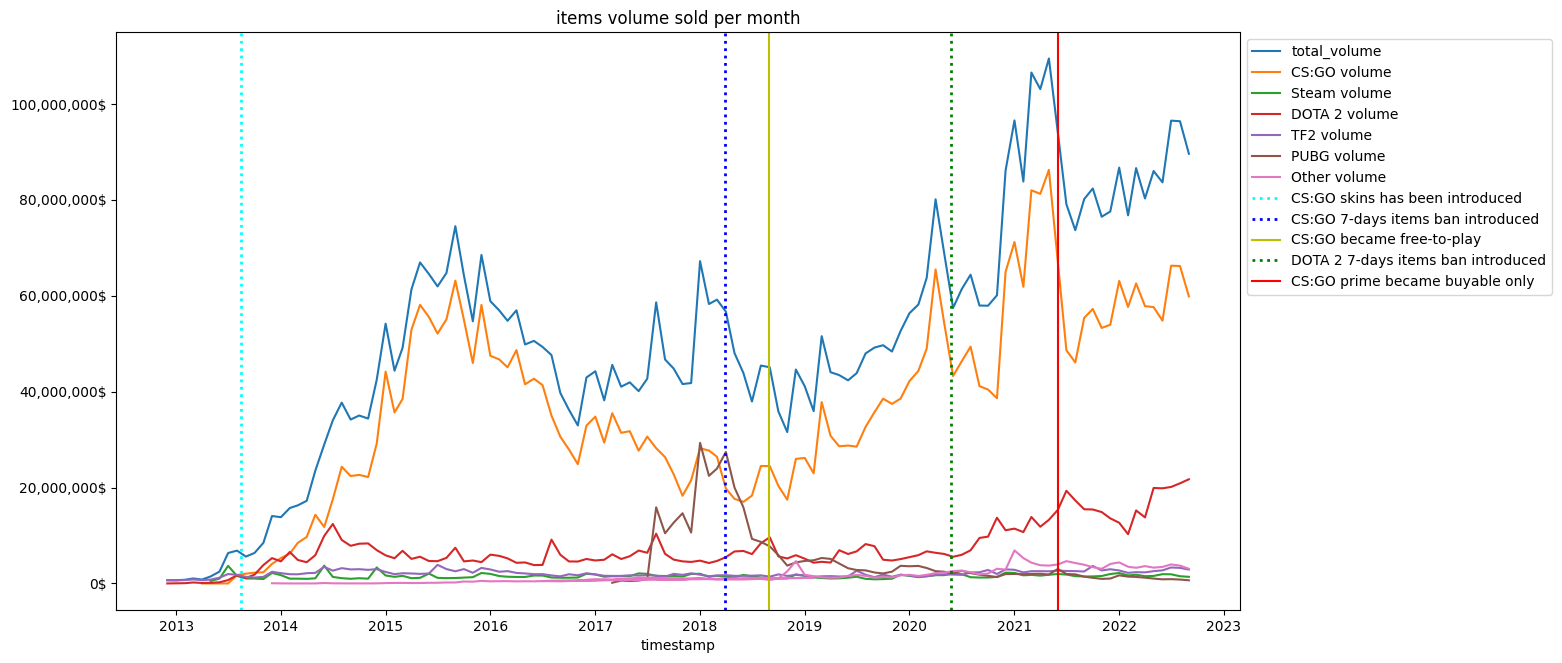

In [22]:
plot_end = datetime(2022, 10, 1) 

total_x = [val.timestamp for val in total_df.filter(total_df.timestamp < plot_end).select('timestamp').collect()]
total_y = [val.total_volume for val in total_df.filter(total_df.timestamp < plot_end).select('total_volume').collect()]

fig, ax = plt.subplots()
fig.set_size_inches(14.5, 7.5)
ax.plot(total_x, total_y, label='total_volume')

APP_IDS = {730: "CS:GO", 753: "Steam", 570: "DOTA 2", 440: "TF2", 578080: "PUBG"}

for app_id, name in APP_IDS.items():
    app_df = sum_df.filter(sum_df.app_id == app_id)
    y_val = [val.total_volume for val in app_df.filter(app_df.timestamp < plot_end).select('total_volume').collect()]
    x_ts = [val.timestamp for val in app_df.filter(app_df.timestamp < plot_end).select('timestamp').collect()]
    plt.plot(x_ts, y_val, label=f'{name} volume')

other_app_df = sum_df
for app_id in APP_IDS.keys():
    other_app_df = other_app_df.filter(other_app_df.app_id != app_id)
other_app_df = other_app_df.groupby("timestamp") \
  .agg( \
    func.sum(sum_df.total_volume).alias("total_volume"), \
  ) \
  .cache()
y_val = [val.total_volume for val in other_app_df.filter(other_app_df.timestamp < plot_end).select('total_volume').collect()]
x_ts = [val.timestamp for val in other_app_df.filter(other_app_df.timestamp < plot_end).select('timestamp').collect()]
plt.plot(x_ts, y_val, label='Other volume')
    
plt.xlabel('timestamp')
plt.title('items volume sold per month')

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')+"$"))
plt.axvline(x=datetime(2013, 8, 14), color='aqua', ls=':', lw=2, label='CS:GO skins has been introduced')
plt.axvline(x=datetime(2018, 3, 30), color='b', ls=':', lw=2, label='CS:GO 7-days items ban introduced')
plt.axvline(x=datetime(2018, 8, 30), color='y', label='CS:GO became free-to-play')
plt.axvline(x=datetime(2020, 5, 26), color='g', ls=':', lw=2, label='DOTA 2 7-days items ban introduced')
plt.axvline(x=datetime(2021, 6, 3), color='r', label='CS:GO prime became buyable only')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

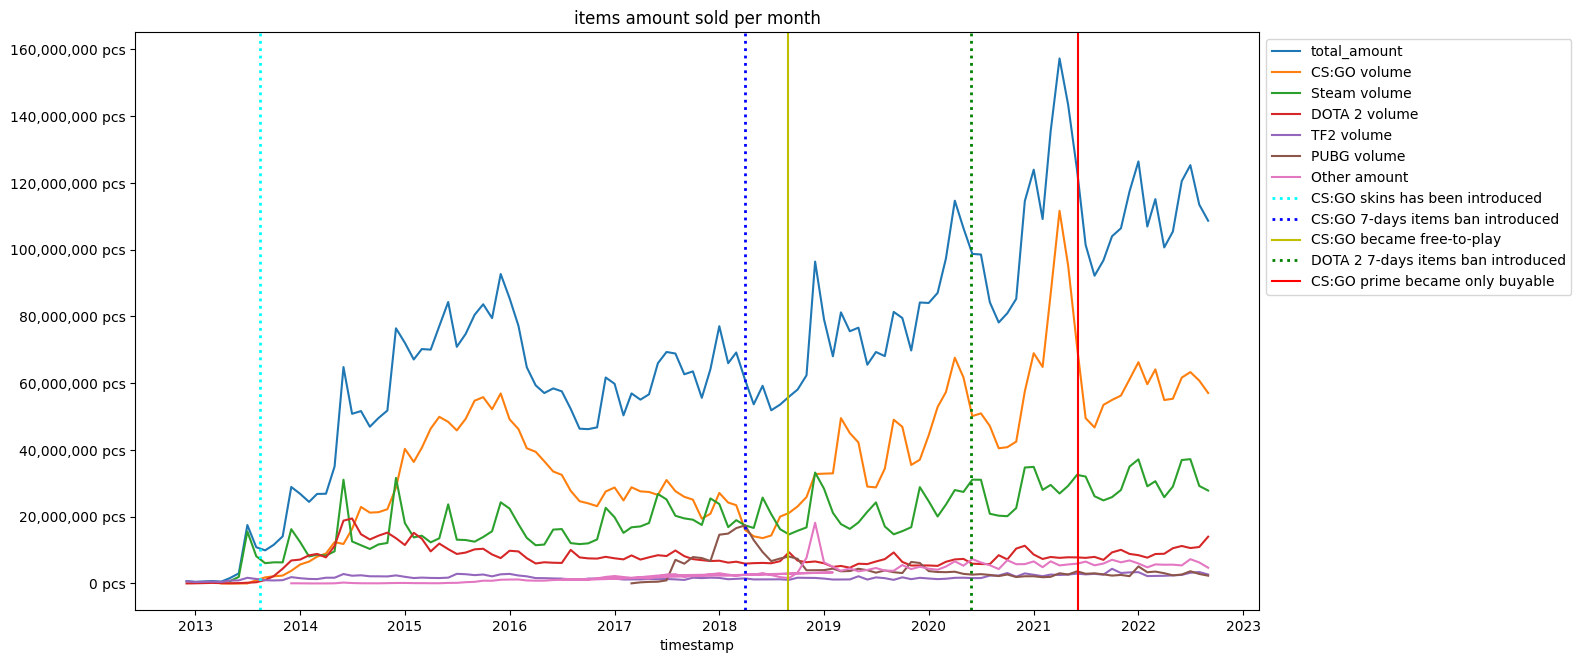

In [23]:
plot_end = datetime(2022, 10, 1) 

total_x = [val.timestamp for val in total_df.filter(total_df.timestamp < plot_end).select('timestamp').collect()]
total_y = [val.total_amount for val in total_df.filter(total_df.timestamp < plot_end).select('total_amount').collect()]

fig, ax = plt.subplots()
fig.set_size_inches(14.5, 7.5)
ax.plot(total_x, total_y, label='total_amount')

APP_IDS = {730: "CS:GO", 753: "Steam", 570: "DOTA 2", 440: "TF2", 578080: "PUBG"}

for app_id, name in APP_IDS.items():
    app_df = sum_df.filter(sum_df.app_id == app_id)
    y_val = [val.total_amount for val in app_df.filter(app_df.timestamp < plot_end).select('total_amount').collect()]
    x_ts = [val.timestamp for val in app_df.filter(app_df.timestamp < plot_end).select('timestamp').collect()]
    plt.plot(x_ts, y_val, label=f'{name} volume')

other_app_df = sum_df
for app_id in APP_IDS.keys():
    other_app_df = other_app_df.filter(other_app_df.app_id != app_id)
other_app_df = other_app_df.groupby("timestamp") \
  .agg( \
    func.sum(sum_df.total_amount).alias("total_amount") \
  ) \
  .cache()
y_val = [val.total_amount for val in other_app_df.filter(other_app_df.timestamp < plot_end).select('total_amount').collect()]
x_ts = [val.timestamp for val in other_app_df.filter(other_app_df.timestamp < plot_end).select('timestamp').collect()]
plt.plot(x_ts, y_val, label='Other amount')

plt.xlabel('timestamp')
plt.title('items amount sold per month')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')+" pcs"))
plt.axvline(x=datetime(2013, 8, 14), color='aqua', ls=':', lw=2, label='CS:GO skins has been introduced')
plt.axvline(x=datetime(2018, 3, 30), color='b', ls=':', lw=2, label='CS:GO 7-days items ban introduced')
plt.axvline(x=datetime(2018, 8, 30), color='y', label='CS:GO became free-to-play')
plt.axvline(x=datetime(2020, 5, 26), color='g', ls=':', lw=2, label='DOTA 2 7-days items ban introduced')
plt.axvline(x=datetime(2021, 6, 3), color='r', label='CS:GO prime became only buyable')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

In [24]:
cached_df = df \
  .groupby("app_id") \
  .agg( \
    func.sum(df.amount).alias("total_sold_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.sum(df.price * df.amount).cast(DecimalType(38, 2)).alias("total_sold_volume"), \
    func.min(df.price).cast(DecimalType(38, 2)).alias("min_price"), \
    func.max(df.price).cast(DecimalType(38, 2)).alias("max_price"), \
    func.count_distinct(df.market_hash_name).alias("market_items_amount") \
  ) \
  .coalesce(1) \
  .sort("total_sold_volume", ascending=False) \
  .cache()

In [25]:
avg_df = df

In [26]:
WINDOW_SIZE = 10
w1 = W.partitionBy('market_hash_name').orderBy('timestamp').rowsBetween(W.currentRow, WINDOW_SIZE-1)
# TODO: calc total_market_items in another df/query
# w2 = W.partitionBy('market_hash_name').orderBy('timestamp').rowsBetween(W.unboundedPreceding, W.currentRow)
    #.filter(func.col("app_id") == 730) \
    #.repartition(3000) \
total_avg_df = avg_df\
    .withColumn("timestamp", func.date_trunc("mon", func.col("timestamp")))\
    .select(
        'market_hash_name',
        func.round(func.sum('price').over(w1) / func.count('price').over(w1), 2).alias('sum'),
        func.sum('amount').over(w1).alias('amount'),
        func.max("timestamp").over(w1).alias("est_timestamp"),
    )\
    .groupBy("est_timestamp")\
    .agg(
        func.round(func.sum("sum") / func.count("sum"), 2).alias("sum"),
        func.sum('amount').alias('amount'),
        # func.sum("total_market_items").alias("total_market_items"),
    )\
    .orderBy("est_timestamp") \
    .cache()
total_avg_df.show(20, False)

+-------------------+----+---------+
|est_timestamp      |sum |amount   |
+-------------------+----+---------+
|2012-12-01 00:00:00|1.32|3697792  |
|2013-01-01 00:00:00|3.71|4683804  |
|2013-02-01 00:00:00|5.15|5788246  |
|2013-03-01 00:00:00|5.5 |6486763  |
|2013-04-01 00:00:00|5.38|5680826  |
|2013-05-01 00:00:00|4.77|11760362 |
|2013-06-01 00:00:00|4.74|22004456 |
|2013-07-01 00:00:00|4.3 |126796331|
|2013-08-01 00:00:00|2.52|105785401|
|2013-09-01 00:00:00|2.91|91334745 |
|2013-10-01 00:00:00|2.93|113261919|
|2013-11-01 00:00:00|2.98|121304769|
|2013-12-01 00:00:00|3.13|251850804|
|2014-01-01 00:00:00|3.34|290753842|
|2014-02-01 00:00:00|3.26|231383745|
|2014-03-01 00:00:00|3.28|259586061|
|2014-04-01 00:00:00|3.36|265098138|
|2014-05-01 00:00:00|3.19|328205641|
|2014-06-01 00:00:00|2.98|559546932|
|2014-07-01 00:00:00|3.11|555858905|
+-------------------+----+---------+
only showing top 20 rows



In [27]:
total_avg_df.count()

120

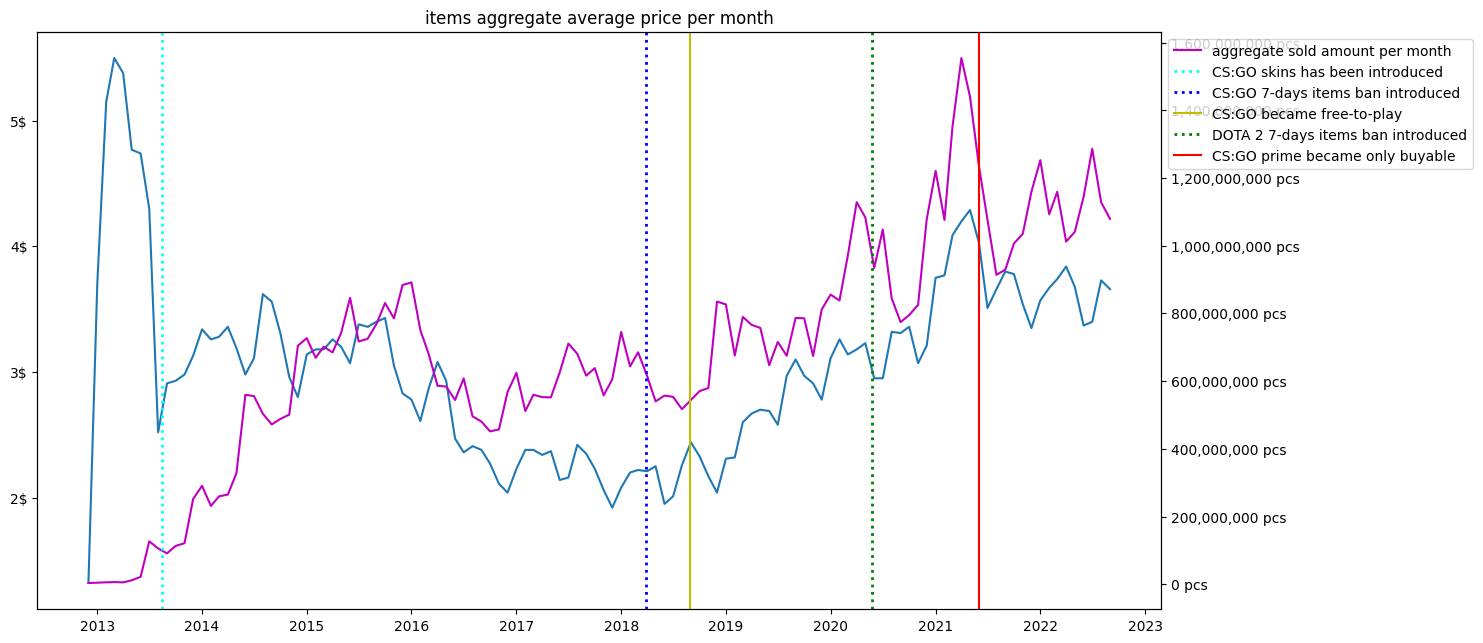

In [28]:
plot_end = datetime(2022, 10, 1)

trunc_total_avg_df = total_avg_df
total_x = [val.est_timestamp for val in trunc_total_avg_df.filter(trunc_total_avg_df.est_timestamp < plot_end).select('est_timestamp').collect()]
total_y = [val.sum for val in trunc_total_avg_df.filter(trunc_total_avg_df.est_timestamp < plot_end).select('sum').collect()]
total_amount = [val.amount for val in trunc_total_avg_df.filter(trunc_total_avg_df.est_timestamp < plot_end).select('amount').collect()]

fig, ax = plt.subplots()
fig.set_size_inches(14.5, 7.5)
ax.plot(total_x, total_y, label='aggregate average price')
ax2 = ax.twinx()

ax2.plot(total_x, total_amount, label='aggregate sold amount per month', color='m')
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')+" pcs"))
# ax.plot(total_x, total_amount, label='aggregate amount')

plt.xlabel('timestamp')
plt.title('items aggregate average price per month')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')+"$"))
plt.axvline(x=datetime(2013, 8, 14), color='aqua', ls=':', lw=2, label='CS:GO skins has been introduced')
plt.axvline(x=datetime(2018, 3, 30), color='b', ls=':', lw=2, label='CS:GO 7-days items ban introduced')
plt.axvline(x=datetime(2018, 8, 30), color='y', label='CS:GO became free-to-play')
plt.axvline(x=datetime(2020, 5, 26), color='g', ls=':', lw=2, label='DOTA 2 7-days items ban introduced')
plt.axvline(x=datetime(2021, 6, 3), color='r', label='CS:GO prime became only buyable')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

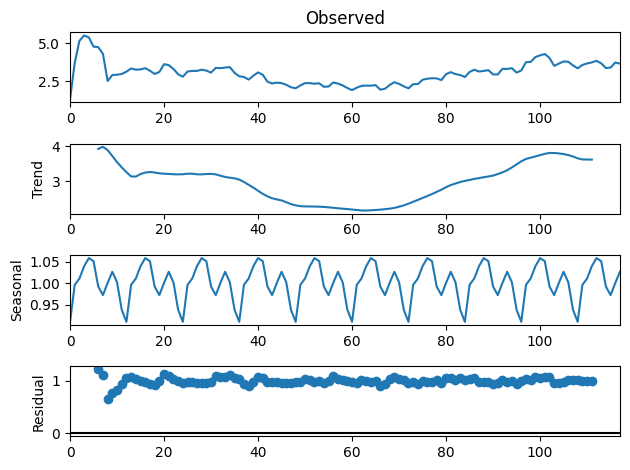

In [30]:
decomposition = seasonal_decompose([x.sum for x in trunc_total_avg_df.filter(trunc_total_avg_df.est_timestamp < plot_end).select('est_timestamp', 'sum').collect()], period=12, model="multiplicative")
fig = decomposition.plot()
plt.show()

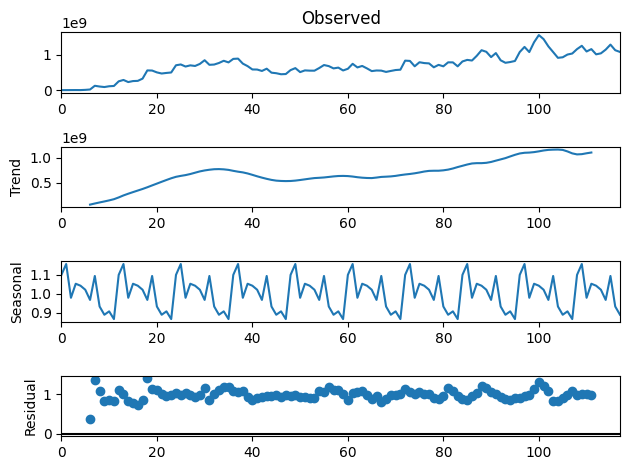

In [31]:
decomposition = seasonal_decompose([x.amount for x in trunc_total_avg_df.filter(trunc_total_avg_df.est_timestamp < plot_end).select('amount').collect()], period=12, model="multiplicative")
fig = decomposition.plot()
plt.show()

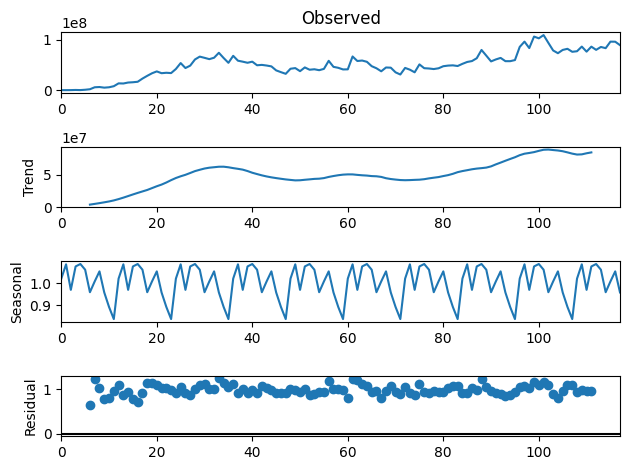

In [32]:
decomposition = seasonal_decompose([val.total_volume for val in total_df.filter(total_df.timestamp < plot_end).select('total_volume').collect()], period=12, model="multiplicative")
fig = decomposition.plot()
plt.show()